# Predict Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. Can download the data from the University of California, Irvine's website ([link](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)).

##  Introduction to the Data Set

Here are the descriptions for columns:

* **instant** - A unique sequential ID number for each row
* **dteday** - The date of the rentals
* **season** - The season in which the rentals occurred
* **yr** - The year the rentals occurred
* **mnth** - The month the rentals occurred
* **hr** - The hour the rentals occurred
* **holiday** - Whether or not the day was a holiday
* **weekday** - The day of the week (as a number, 0 to 7)
* **workingday** - Whether or not the day was a working day
* **weathersit** - The weather (as a categorical variable)
* **temp** - The temperature, on a 0-1 scale
* **atemp** - The adjusted temperature
* **hum** - The humidity, on a 0-1 scale
* **windspeed** - The wind speed, on a 0-1 scale
* **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* **registered** - The number of registered riders (people who had already signed up)
* **cnt** - The total number of bike rentals (casual + registered)

Try to predict the total number of bikes people rented in a given hour. To accomplish this, let's create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


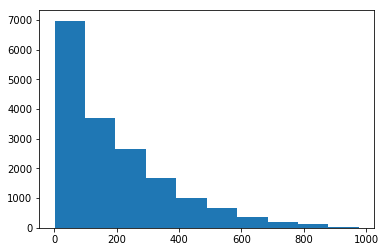

In [2]:
# make a histogram of the cnt column
plt.hist(bike_rentals['cnt'])
plt.show()

In [3]:
# explore how each column is correlated with cnt
bike_rentals.corr()['cnt'].abs()

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday       0.030927
weekday       0.026900
workingday    0.030284
weathersit    0.142426
temp          0.404772
atemp         0.400929
hum           0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculate Features

It can be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. Better introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [4]:
# helper function to create labels for hours of the day
def assign_label(hour_value):
    morning = [6, 7, 8, 9, 10, 11]
    afternoon = [12, 13, 14, 15, 16, 17]
    evening = [18, 19, 20, 21, 22, 23]
    night = [0, 1, 2, 3, 4, 5]
    
    if hour_value in morning:
        day_time = 1
    elif hour_value in afternoon:
        day_time = 2
    elif hour_value in evening:
        day_time = 3
    elif hour_value in night:
        day_time = 4
    return day_time

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


## Split the Data Into Train and Test Sets

The values that are going to predict are continuos, so the better metric to evaluate learning algorithm is mean squared error.

In [5]:
# select 80% of the rows in bike_rentals to be part of the training set
train = bike_rentals.sample(n=int(.8*bike_rentals.shape[0]), random_state=1)
# select rest of the rows into test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13903, 18)
(3476, 18)


## Apply Linear Regression

Ignore the `casual` and `registered` columns because `cnt` is derived from them. 

In [6]:
features = bike_rentals.columns.drop(['instant', 'cnt', 'casual', 'dteday', 'registered'])
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [7]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])
error = mean_squared_error(test['cnt'], predictions)
error

17054.9594635403

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Apply Decision Trees

In [8]:
dtr = DecisionTreeRegressor(min_samples_leaf=7)
dtr.fit(train[features], train['cnt'])
predictions = dtr.predict(test[features])
error = mean_squared_error(test['cnt'], predictions)
error

2888.1767920789002

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

##  Apply Random Forests

In [9]:
rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)
rfr.fit(train[features], train['cnt'])
predictions = rfr.predict(test[features])
error = mean_squared_error(test['cnt'], predictions)
error

1939.001273843489

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.